In [84]:
import pandas as pd
#Step-1: Load Dataset
data = pd.read_csv("/kaggle/input/optical-recognition-of-handwritten-digits/optdigits.tra",header=None) 
#Header is None as we don't want the first column to be treated as header by default
test = pd.read_csv("/kaggle/input/optical-recognition-of-handwritten-digits/optdigits.tes",header=None)
#Step-2: Train and Test data splitting
#Finding the target variable, it is assumed to be the last column, let us check, the target column has values only in the range of 0-9.
last_col = data.iloc[:,-1]
print("Unique values of the last column:",last_col.unique())
#So,as the last column has only values ranging from 0-9, it is the target variable
X_train = data.iloc[:,:-1].copy()   #The point of .copy() is to make sure you’re working on your own dataset, not a window into the old one.
y_train = data.iloc[:,-1] .copy()   
X_test = test.iloc[:,:-1].copy()
y_test = test.iloc[:,-1].copy()
#Step-3: Preview the split dataset
print("Train data:\n",X_train.head(3))
print("Test data:\n",X_test.head(3))

Unique values of the last column: [0 7 4 6 2 5 8 1 9 3]
Train data:
    0   1   2   3   4   5   6   7   8   9   ...  54  55  56  57  58  59  60  \
0   0   1   6  15  12   1   0   0   0   7  ...   0   0   0   0   6  14   7   
1   0   0  10  16   6   0   0   0   0   7  ...   3   0   0   0  10  16  15   
2   0   0   8  15  16  13   0   0   0   1  ...   0   0   0   0   9  14   0   

   61  62  63  
0   1   0   0  
1   3   0   0  
2   0   0   0  

[3 rows x 64 columns]
Test data:
    0   1   2   3   4   5   6   7   8   9   ...  54  55  56  57  58  59  60  \
0   0   0   5  13   9   1   0   0   0   0  ...   0   0   0   0   6  13  10   
1   0   0   0  12  13   5   0   0   0   0  ...   0   0   0   0   0  11  16   
2   0   0   0   4  15  12   0   0   0   0  ...   5   0   0   0   0   3  11   

   61  62  63  
0   0   0   0  
1  10   0   0  
2  16   9   0  

[3 rows x 64 columns]


In [85]:
#Step-4: Preprocessing
#4a) Handling Missing values
X_train.fillna(X_train.mean(),inplace=True) #fillna using train set mean
X_test.fillna(X_train.mean(),inplace=True) #fillna using train set mean only
#4b) Scaling
#MinMaxScaler: simple, preserves pixel intensity ratios, recommended for images/logistic regression.
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)  #fit_transform-compute and apply
X_test = scaler.transform(X_test)  #transform-apply
#4c) Feature Selection - Filter methods
from sklearn.feature_selection import VarianceThreshold
#Constant Feature
const_filter = VarianceThreshold(threshold=0)
X_train = const_filter.fit_transform(X_train)
X_test = const_filter.transform(X_test)  
print("The Removed features are:")
import numpy as np
for i in range(len(const_filter.variances_)):
    if(const_filter.variances_[i]==0):
        print(f"Feature {i} is removed as it has constant variance")
#Quasi constant features
quasi_constant_filter = VarianceThreshold(threshold=0.01)
X_train = quasi_constant_filter.fit_transform(X_train)
X_test = quasi_constant_filter.transform(X_test)
import numpy as np
for i in range(len(quasi_constant_filter.variances_)):
    if(quasi_constant_filter.variances_[i]<=0.01):
        print(f"Feature {i} is removed as it has variance={quasi_constant_filter.variances_[i]}")
#Duplicates
duplicates = []
for i in range(X_train.shape[1]):
    for j in range(i+1,X_train.shape[1]):
        if(np.array_equal(X_train[:,i],X_train[:,j])):
            duplicates.append(X_train[:,j])
print("Duplicate features:",duplicates)
X_train = np.delete(X_train,duplicates,axis=1)
X_test = np.delete(X_test,duplicates,axis=1)

The Removed features are:
Feature 0 is removed as it has constant variance
Feature 39 is removed as it has constant variance
Feature 6 is removed as it has variance=0.004318629262468195
Feature 7 is removed as it has variance=0.0003137144569239597
Feature 14 is removed as it has variance=0.004344119033440089
Feature 15 is removed as it has variance=0.0005744762912966244
Feature 22 is removed as it has variance=0.0029621489362298987
Feature 23 is removed as it has variance=0.0010452039772761868
Feature 30 is removed as it has variance=0.0010438355510163336
Feature 31 is removed as it has variance=0.0013061628650302708
Feature 38 is removed as it has variance=0.0020398348297774984
Feature 45 is removed as it has variance=0.001267831725018149
Feature 46 is removed as it has variance=0.0007240138076946473
Feature 53 is removed as it has variance=0.004092384212949751
Feature 54 is removed as it has variance=0.00026150625825802483
Feature 55 is removed as it has variance=0.008610432238644784

###  Objective of Logistic Regression with L2 Regularization

The objective of logistic regression with L2 regularization is to learn the weights of the model that minimize the error on the training data while preventing overfitting. This is done by minimizing the **regularized cross-entropy loss**, which consists of two parts:

1. **Cross-Entropy Loss**: Measures how well the model predicts the training labels.  
2. **L2 Regularization Term**: Penalizes large weights to reduce model complexity and prevent overfitting.

In simple words, the model tries to **fit the data accurately** (by reducing the prediction error) while **keeping the weights small** (to avoid overfitting). It assumes that are features are good and doens't eleminate any of them completely but make them as small as possible. Basically, prevents one feature from having an overly dominant effect on the predictions.

**λ (lambda)** controls how strongly the weights are penalized:
**λ = 0** → No regularization → risk of overfitting.
**Large λ** → Strong regularization → weights shrink → may underfit.
The goal is to observe how the model’s performance, weights, and complexity change as you vary λ.

In [86]:
#Step-5: Logistic Regression model with L2 Regularization
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss,accuracy_score
lambdas = [0, 0.1, 1, 10, 100, 1000]
#In scikit-learn, the regularization parameter is not λ directly, but C, which is the inverse of λ
#Large λ → strong regularization → small C
#Small λ → weak regularization → large C
models = []
train_acc = []
test_acc = []
weight_norms = []
train_loss = []
test_loss = []
for i in lambdas:
    if(i==0):
        c=1e12 #Practically no c value, scikit-learn expects a finite c, so 1e12 is a safe practical workaround for λ = 0.
    else:
        c=1/i

    #Fit the model
    model = LogisticRegression(penalty="l2",C=c,solver="lbfgs",max_iter=1000,multi_class="auto")
    # The solver ('lbfgs') finds weights that minimize the loss, which includes both cross-entropy and the L2 penalty controlled by C (inverse of λ)
    # max_iter tells try till that number of iterations,multi_class auto will give ability to choose the classes based on requirement
    model.fit(X_train,y_train)
    models.append(model)
    #Predictions
    # Predict on training features X_train to get predicted probabilities y_train_pred for comparison with true labels y_train
    y_train_pred = model.predict_proba(X_train)
    y_test_pred = model.predict_proba(X_test)
    # Cross-entropy loss
    train_loss.append(log_loss(y_train,y_train_pred))
    test_loss.append(log_loss(y_test,y_test_pred))
    # L2 norm of weights
    weight_norms.append(np.linalg.norm(model.coef_))
    # Accuracy   
    train_acc.append(model.score(X_train, y_train))
    test_acc.append(model.score(X_test, y_test))
    #Quickly observing all
    print("Lambda:", i)
    print("Training Loss:", train_loss)
    print("Testing Loss:", test_loss)
    print("Weight Norms:", weight_norms)
    print("Training Accuracy:", train_acc)
    print("Testing Accuracy:", test_acc)

Lambda: 0
Training Loss: [7.214460580893854e-08]
Testing Loss: [1.7987994137493424]
Weight Norms: [3602.5705027492404]
Training Accuracy: [1.0]
Testing Accuracy: [0.9393433500278241]
Lambda: 0.1
Training Loss: [7.214460580893854e-08, 0.039471901036085257]
Testing Loss: [1.7987994137493424, 0.1428475230784189]
Weight Norms: [3602.5705027492404, 42.98886401820134]
Training Accuracy: [1.0, 0.9918911849332984]
Testing Accuracy: [0.9393433500278241, 0.9504730105731776]
Lambda: 1
Training Loss: [7.214460580893854e-08, 0.039471901036085257, 0.09262871797497692]
Testing Loss: [1.7987994137493424, 0.1428475230784189, 0.16215992945186963]
Weight Norms: [3602.5705027492404, 42.98886401820134, 21.503922957767372]
Training Accuracy: [1.0, 0.9918911849332984, 0.9801203243526027]
Testing Accuracy: [0.9393433500278241, 0.9504730105731776, 0.9465776293823038]
Lambda: 10
Training Loss: [7.214460580893854e-08, 0.039471901036085257, 0.09262871797497692, 0.22562065105482826]
Testing Loss: [1.79879941374934

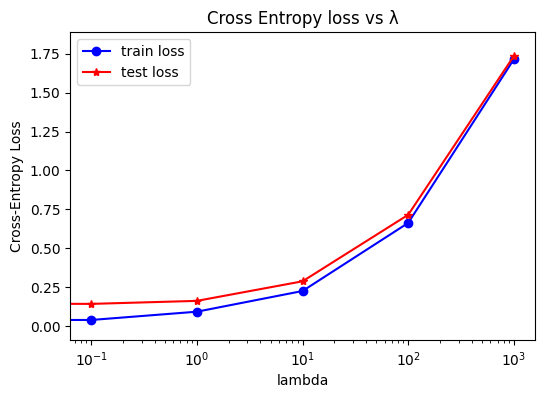

In [87]:
#Step-6: Visualizing
#6a)
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(lambdas,train_loss,marker="o",color="Blue",label="train loss")
plt.plot(lambdas,test_loss,marker="*",color="Red",label="test loss")
plt.xlabel("lambda")
plt.ylabel("Cross-Entropy Loss")
plt.title("Cross Entropy loss vs λ")
# Use logarithmic scale on X-axis so λ values spread evenly across orders of magnitude (0.1, 1, 10, 100, 1000)
plt.xscale("log")
plt.legend()
plt.show()

## Observation:
This plot illustrates how training and testing cross-entropy loss change with increasing λ (regularization strength). For small λ (weak regularization), the model fits the training data closely, so training loss is low, but test loss can be higher due to overfitting. As λ increases, stronger regularization prevents overfitting, causing training loss to rise slightly while test loss initially decreases, reflecting better generalization. For very large λ, both training and test loss increase because the model becomes too constrained, underfitting the data. The log scale on λ makes it easier to observe these trends across multiple orders of magnitude.

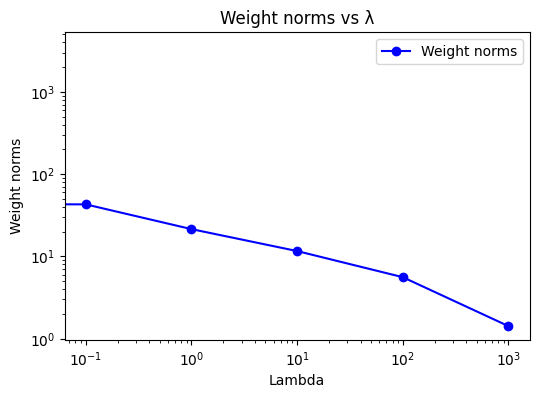

In [88]:
#6b)
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(lambdas,weight_norms,marker="o",color="blue",label = "Weight norms")
plt.xlabel("Lambda")
plt.ylabel("Weight norms")
plt.title("Weight norms vs λ")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()


## Observation:
This plot shows how the L2 norm of the model’s weights changes with increasing λ. As λ increases, regularization becomes stronger, which shrinks the overall magnitude of the weights, reducing overfitting. For small λ (weak regularization), the weight norm is larger because the model can freely adjust weights to fit the training data. For very large λ, the weight norm drops significantly as the model is constrained, indicating that the model relies less on individual features and emphasizes generalization. The log-log scale highlights these changes across orders of magnitude clearly.

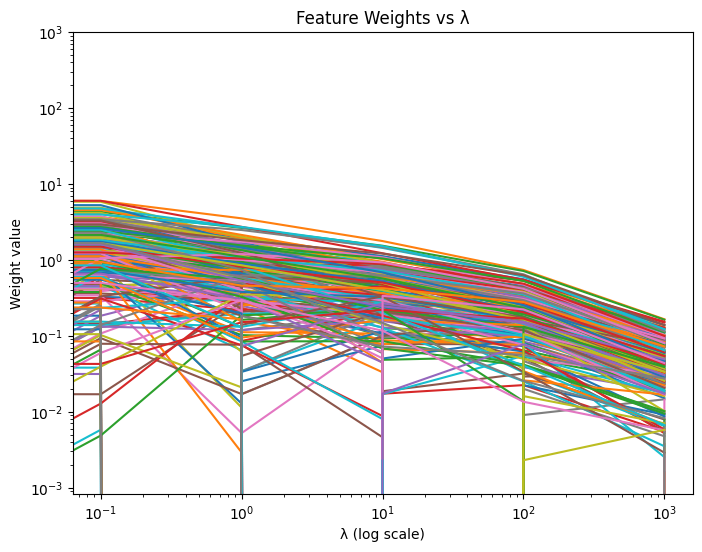

In [89]:
# 6c). Weights per feature vs λ
plt.figure(figsize=(8,6))
coefs = np.array([m.coef_.ravel() for m in models])  # models must be saved in loop
for i in range(coefs.shape[1]):
    plt.plot(lambdas, coefs[:, i], label=f"Feature {i}")
plt.xlabel("λ (log scale)")
plt.ylabel("Weight value")
plt.title("Feature Weights vs λ")
plt.xscale("log")
plt.yscale("log")
plt.show()
#As many features the graph looks clumsy

## Observation:
In this plot, we observe how the weights of individual features change with increasing λ (regularization strength) in L2-regularized logistic regression. As λ increases, the regularization becomes stronger, forcing the model to shrink the weights toward zero to prevent overfitting. Features with consistently high weights are more important for predicting the class, while features whose weights quickly decay toward zero contribute less. For very large λ, almost all weights collapse near zero, indicating that the model relies less on individual features and more on general patterns. The plot also shows that many features have small or negligible weights, which is typical for high-dimensional image data where not all pixels are informative.

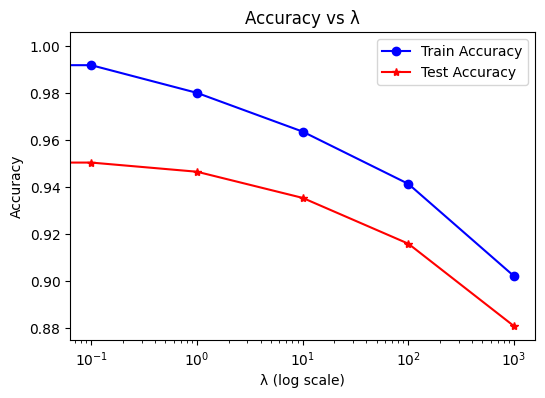

In [90]:
#6d)
plt.figure(figsize=(6,4))
plt.plot(lambdas, train_acc, marker="o", color="blue", label="Train Accuracy")
plt.plot(lambdas, test_acc, marker="*", color="red", label="Test Accuracy")
plt.xlabel("λ (log scale)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs λ")
plt.xscale("log")
plt.legend()
plt.show()

## Observation:
This plot shows how training and testing accuracy vary with increasing λ. For small λ (weak regularization), the model fits the training data very well, so training accuracy is high, but test accuracy may be slightly lower due to overfitting. As λ increases, stronger regularization reduces overfitting, which can slightly decrease training accuracy while improving or stabilizing test accuracy. For very large λ, both training and test accuracy drop because the model is too constrained and starts underfitting. Using a log scale on λ allows clear visualization of accuracy trends across different regularization strengths.